# **A Comparative Evaluation of ARIMA, SARIMA, and XGBoost Models for India’s CPI Inflation Forecasting**





# **Sections**

## **Section 1: Introduction**
## **Section 2: Data Preparation and Visualization**
## **Section 3: Seasonality Tests**
### **Section 3.1. Preliminary Seasonality Tests Using STL and ACF**
### **Section 3.2. Final Seasonality Test - CH Test**
## **Section 4: 5-year Forecast**
### **Section 4.1. ARIMA (Autoregressive Integrated Moving Average)**
### **Section 4.2. SARIMA (Seasonal Autoregressive Integrated Moving Average)**
### **Section 4.3. XGBoost - Extreme Gradient Boosting (with imputed data) - CUDA Enabled**




---------------------------------------------------------------------------------------------------------------




## **Section 1: Introduction**
This notebook intends to analyze, compare and provide insights on the performance of three well known models (2 statistical and 1 machine learning) - ARIMA, SARIMA and XGBoost across the 3 parameters specifically answering the following questions:

1. In-Sample: How well the model describes and fits the training data - measured using log-likelihood, AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion) and p-values of model coefficients - for the 2 statistical models only.
2. Out-of-Sample: How well the model forecasts previously unseen data (test data) - measured using RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) - across all 3 models.
3. Viability of Long-Run Forecasts: How economically plausible or structurally meaningful the long-run forecasts appear - assessed using qualitative and contextual judgment, given the absence of exogenous macroeconomic drivers.

Additionally, the notebook explains the underlying engine - both mathematically and intuitively - of each model - to provide the reader with a clear understanding of what goes on under the hood for each model.

The analysis uses the official All-India Consumer Price Index (CPI – Combined) year-on-year (YoY) inflation series (January-2013 to August-2025) published by the Ministry of Statistics & Programme Implementation (MoSPI), Government of India. MoSPI’s CPI (Base Year 2012 = 100) is the standard measure of retail price inflation and is released monthly through the National Statistical Office (NSO) press-release annexures. Since prior to 2012 India did not report on a **Combined** CPI figure (and base years fluctuated: 2001, 1986-87, 1984-85), we have limited our dataset to 12 years and 6 months. While this limits our historical vantage point, inclusion of statistically significant exogenous factors (over the same period) drastically improve model performance.


**Dataset Description:**

The dataset employed here spans January 2013 through August 2025 and provides the monthly percentage change in the General CPI over the corresponding month of the previous year. One calendar year—2020—has been imputed due to lack of information for some months. This year coincides with the peak of the COVID-19 pandemic, when India experienced:

1. Unprecedented supply-chain disruptions and demand shocks,
2. Nation-wide lockdowns and abrupt changes in consumption patterns, and
3. Gaps in official data collection, with MoSPI itself noting that CPI for April–May 2020 could not be compiled.

Since both ARIMA and SARIMA require continuous monthly data, inflation figures for 2020 have been imputed using STL.

Augmenting ARIMA and SARIMA with exogenous factors have been known to improve overall model performance and hence, this notebook identifies the following 4 factors that will be used with ARIMA and SARIMA to improve model performance:

1. F&B inflation - Food and beverages make up ~46% of India's goods basket and hence, will play a major role in our model - Source:  
2. Brent crude prices - India imports 85% of its oil and hence, this factor will play a key role in modelling the inflation rate - Source: FRED (Federal Reserve Bank of St. Louis).
3. INR/USD exchange rate - India imports commodities, energy, machinery and hence any movement (aprpeciation/ depreciation) will play a key role in our model - Source: DBIE (Database on Indian Economy).
4. Repo (repurchase option) rate - RBI policy rate is a key determinant of demand-side inflation and hence, data on the same will also play a key role in our model - Source: MasterstrokeOnline (2013-23), 2024 rates extrapolated from 2023 (since no reported MPC meeting held) and 2025 rates taken from RBI press release.

**Modelling Approach:**

Subsequent sections of this notebook outline the data-preparation steps, stationarity diagnostics, and the implementation of: 

- Two classical time-series models—specifically ARIMA/SARIMA variants and, 
- One supervised ML model (XGBoost)

These models are used to generate monthly forecasts of India’s headline inflation for the next 60 months (September-2025 to August-2030). These projections are then evaluated to compare each model’s long-run behavior, stability, and economic viability.

**DISCLAIMER:** This notebook is solely for comparative and research purposes, and does **NOT** intend to conclusively determine long-run forecasts for any form of financial/ economic interpretation. Accurate long run forecasts require the presence of multiple exogenous variables that have not been considered as part of this research. Hence, long-horizon projections should be interpreted as indicative - rather than definitive.

In [80]:
# Importing necessary packages for the model
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
from pmdarima.arima import CHTest
from scipy.stats import pearsonr
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
warnings.simplefilter("ignore")
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss
import xgboost as xgb

## **Section 2: Data Preparation and Visualization**
This section shows a visual representation of the inflation data - as sourced from MoSPI, performs imputation of missing data (using seasonality decomposition) and plots the imputed dataset for comparison with the original.

Revised inflation dataset - after setting date as index:
            CPI_Inflation_YoY_Percent
Date                                 
2013-01-01                      10.38
2013-02-01                      10.51
2013-03-01                       9.97
2013-04-01                       9.00
2013-05-01                       8.72


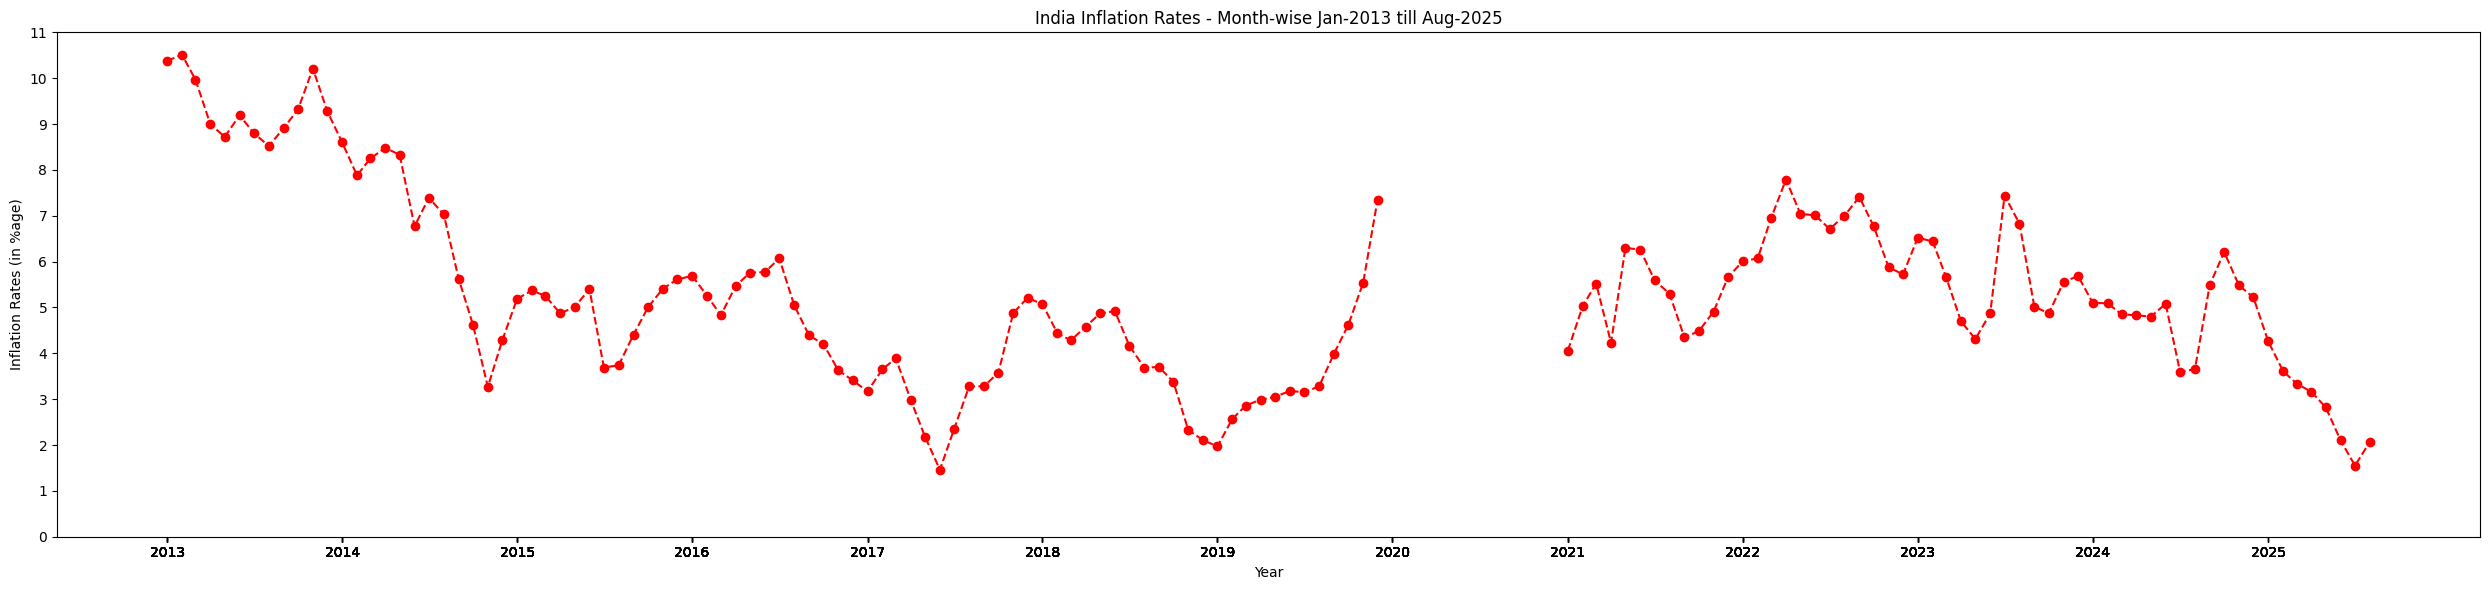

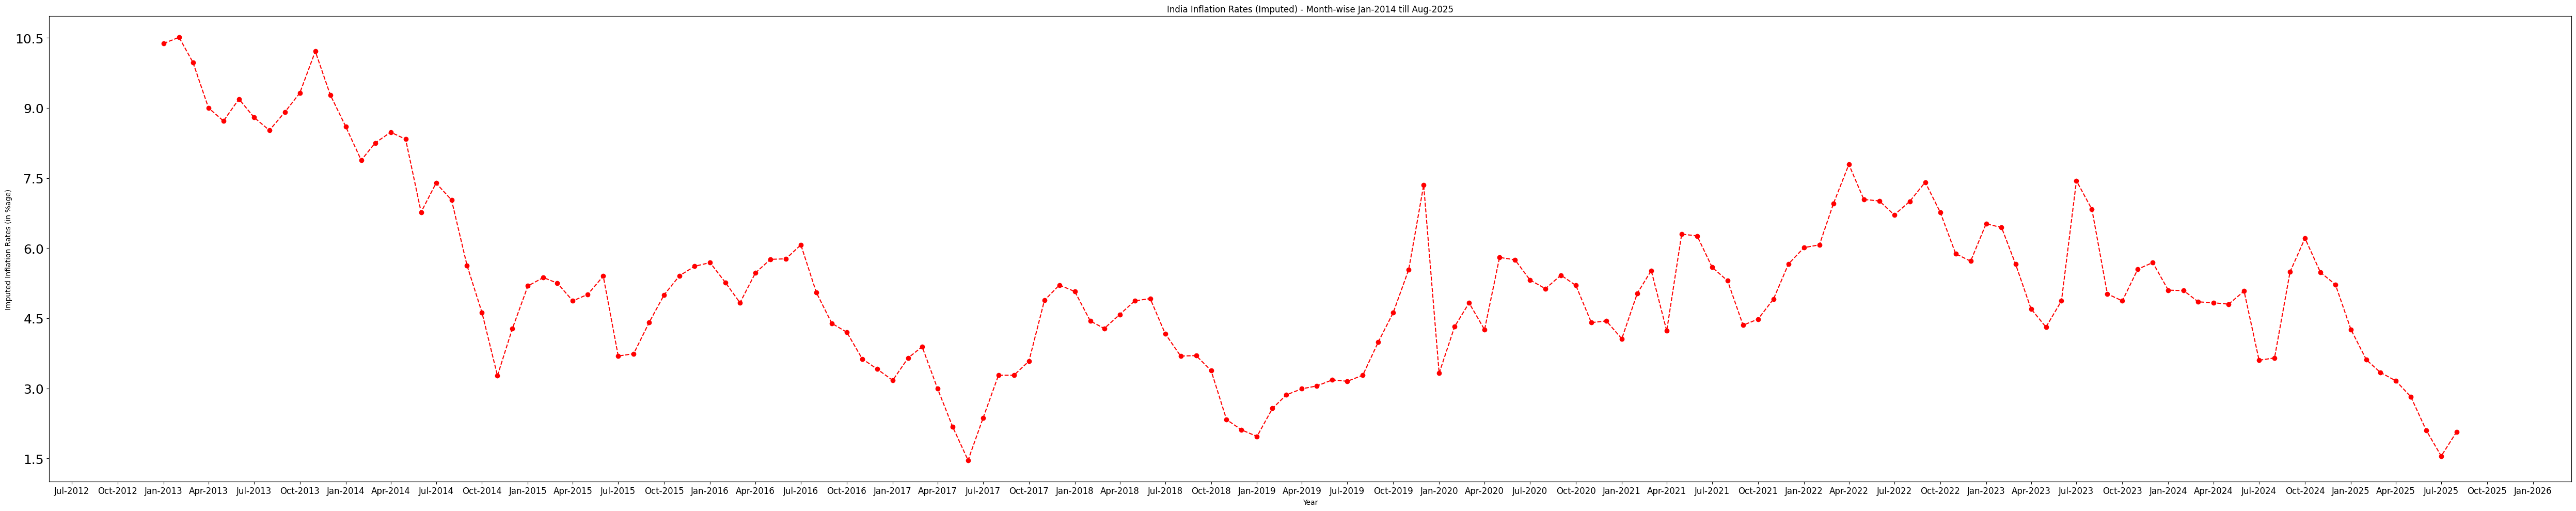

In [81]:
# Initialize environment and set conditions
load_dotenv()
inflation_dataset = os.getenv('inflation_dataset')
forecast_imputed_dataset = os.getenv('forecast_imputed_dataset')
sarima_forecast_imputed_dataset = os.getenv('sarima_forecast_imputed_dataset')
xgboost_forecast_imputed_dataset = os.getenv('xgboost_forecast_imputed_dataset')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load original data
df_inflation = pd.read_csv(inflation_dataset)
X_values = [dt.strptime(d, '%m/%d/%Y') for d in df_inflation['Date']]
Y_values = df_inflation['CPI_Inflation_YoY_Percent'].to_list()
Y_ticks = [round(i) for i in range(int(max(Y_values)+2))]
X_ticks = [dt.strftime(d, '%Y') for d in X_values]

# Visualize original data
fig, ax = plt.subplots(figsize=(25, 6), dpi=100)
ax.plot(X_values, Y_values, '--', color='red', marker='o')
ax.set_title('India Inflation Rates - Month-wise Jan-2013 till Aug-2025')
ax.set_xlabel('Year')
ax.set_ylabel('Inflation Rates (in %age)')
ax.set_xticks(X_ticks)
ax.set_yticks(Y_ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

# Setting date as index, converting to monthly frequency and generating time interpolated data.
df_inflation['Date'] = pd.to_datetime(df_inflation['Date'])
df_inflation_imputed = pd.DataFrame(df_inflation)
df_inflation_imputed.set_index('Date', inplace=True)
df_inflation_imputed = df_inflation_imputed.asfreq('MS')
df_inflation_imputed = df_inflation_imputed.sort_index()
print(f'Revised inflation dataset - after setting date as index:\n{df_inflation_imputed.head(5)}')
date_tmp = df_inflation_imputed['CPI_Inflation_YoY_Percent'].interpolate(method='time') # Interpolating the data to capture structure.

# Imputing missing values using STL.
stl = STL(date_tmp, period=12, robust=True).fit() # Performing seasonal decomposition on interpolated data.
trend, seasonality = stl.trend, stl.seasonal
fill_values = trend + seasonality
df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'] = df_inflation_imputed['CPI_Inflation_YoY_Percent'].fillna(fill_values)

# Plotting the imputed data
X_series = df_inflation_imputed.index
Y_series = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed']
fig, ax = plt.subplots(figsize=(50, 10), dpi=100)
ax.plot(X_series, Y_series, '--', color='red', marker='o')
ax.set_title('India Inflation Rates (Imputed) - Month-wise Jan-2014 till Aug-2025')
ax.set_xlabel('Year')
ax.set_ylabel('Imputed Inflation Rates (in %age)')
ax.set_xticks(X_series)
ax.set_yticks(Y_series)
ax.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=18)
fig.tight_layout()
plt.show()

# Training and Testing Data Preparation
train_imputed_data = df_inflation_imputed[
    (df_inflation_imputed.index >= '2013-01-01') & (df_inflation_imputed.index <= '2024-08-01')
]
test_imputed_data = df_inflation_imputed[
    df_inflation_imputed.index > '2024-08-01'
]


## **Section 3: Introduction to Time-Series Models, Trend Stationarity Test and Differencing**
Time series models typically use the additive or multiplicative methods - with additive being the most widely adopted. Under the additive method, following are the typical equations of a time-series model:

For an additive decomposition (as explained in Section 3 above):
$$
y_t = T_t + S_t + R_t,
$$
where $$T_t = trend, S_t = seasonal component, R_t = remainder (noise).$$

For multiplicative behavior, use a log transform and decompose additively:
$$
\log y_t = T_t + S_t + R_t \quad \iff \quad y_t = e^{T_t}\cdot e^{S_t}\cdot e^{R_t}.
$$

**Additive vs. multiplicative?**
- If amplitude is roughly **constant** - which is typically the case for inflation rates, use **additive**.
- If amplitude **scales with the level** - typically seen in revenue, sales data, decompose **log(y)** additively (equivalently multiplicative on \(y\)).

A fundamental requirement for classical time-series models such as ARIMA and SARIMAX is **stationarity**. A stationary series is one whose statistical properties (mean, variance and autocorrelation structure) do not change over time. Non-stationary data leads to spurious regressions and invalid significance tests. A key point to note: stabilizing the data does **NOT** mean modifying or diluting the raw dataset. Stabilization just improves the data for improved pattern recognition.

This section uses the **Augmented Dickey Fuller (ADF) and Kwiatkowski-Phillips-Schmit-Shin (KPSS)** tests to determine if the trend-series is stationary and if not, differences the data (to make the data stationary). The differenced data is then passed through seasonality tests and the final dataset is then used into the appropriate time-series model.

In practice, ADF and KPSS are used **together** to diagnose trend stationarity:

- ADF non-stationary + KPSS stationary → difference-stationary.
- ADF stationary + KPSS non-stationary → trend-stationary.
- Both stationary or both non-stationary → conclusions confirmed.

This dual testing approach is standard in econometric analysis prior to applying ARIMA/SARIMA models.

### **3.1. Trend Stationarity Test Using ADF**
This section performs the ADF test on our inflation dataset to determine whether the underlying trend is stationary or not.

#### **About ADF:**
#### ADF: Augmented Dickey–Fuller Test

The **Augmented Dickey–Fuller (ADF)** test is a statistical hypothesis test used to detect the presence of a **unit root** in a time-series. The presence of a unit root indicates **trend non-stationarity**, meaning that the mean and dependence structure of the series change over time.

In simple terms, the ADF test determines whether the observed series is stationary without requiring differencing. A stationary series has constant mean and variance and allows for stable forecasting and statistical inference.

**How ADF works**

The ADF test is based on the following regression:

$$
\Delta y_t = \alpha + \beta\,t + \gamma\,y_{t-1} + \sum_{i=1}^{p}\delta_i\,\Delta y_{t-i} + \varepsilon_t,
$$

where:
- $\Delta y_t$ is the first difference of the series,
- $t$ is an optional deterministic trend,
- $p$ is the number of lagged difference terms,
- $\gamma$ determines whether the series contains a unit root,
- $\varepsilon_t$ is white-noise.

The hypotheses are:

$$
H_0: \gamma = 0 \quad\text{(series has a unit root → non-stationary)},\\
H_1: \gamma < 0 \quad\text{(series is stationary)}.
$$

The test outputs:
1. **ADF statistic** (test statistic),
2. **p-value**,
3. **lag length** used,
4. **critical values** at (1%, 5%, 10%).

**Decision rule**  
Reject $H_0$ if the p-value is below the significance threshold (typically $0.05$) or if the ADF statistic is less than the corresponding critical value.

**Pros vs. Cons**

**Pros**
- Works directly on the raw series without preprocessing.
- Standard method in econometrics for testing unit roots.
- Widely supported in statistical libraries.

**Cons**
- Sensitive to lag selection and structural breaks.
- Low statistical power in short or noisy series.
- Only detects **trend** non-stationarity (not seasonal unit roots).

A typical model selection pipeline uses ADF to determine whether trend differencing is required before applying ARIMA or SARIMA models.

In [82]:
# Stationarity Test - Augmented Dickey Fuller
print('Stationarity Test (ADF) on Imputed Inflation Dataset - Trend Component:')
inflation_adf_test_result = adfuller(df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'])
inflation_adf_test_stat = inflation_adf_test_result[0]
inflation_adf_test_p_value = inflation_adf_test_result[1]
inflation_adf_test_lags_used = inflation_adf_test_result[2]
inflation_adf_test_obs = inflation_adf_test_result[3]
print(f'Test results:')
print(f'Test statistic: {inflation_adf_test_stat}')
print(f'P-value: {inflation_adf_test_p_value}')
print(f'Number of observations: {inflation_adf_test_obs}')
print(f'Lags used: {inflation_adf_test_lags_used}')

print('\nADF Test Conclusion:')
if inflation_adf_test_p_value > 0.05:
    print('Failed to Reject Ho: Series has a unit root - non-stationary. Trend differencing needed.')
else:
    print('Reject Ho: Series does not have a unit root - stationary. Trend differencing not needed.')

Stationarity Test (ADF) on Imputed Inflation Dataset - Trend Component:
Test results:
Test statistic: -2.52013645390992
P-value: 0.11065146297308648
Number of observations: 138
Lags used: 13

ADF Test Conclusion:
Failed to Reject Ho: Series has a unit root - non-stationary. Trend differencing needed.


### **3.2. Trend Stationarity Test Using KPSS**
This section performs the KPSS test on our inflation dataset to determine whether the underlying trend is stationary or not.

#### **About KPSS:**
#### KPSS: Kwiatkowski–Phillips–Schmidt–Shin Test

The **KPSS (Kwiatkowski–Phillips–Schmidt–Shin)** test is a complementary unit-root test to ADF. Unlike ADF, which assumes the series is non-stationary under the null hypothesis, the KPSS test assumes the opposite:

$$
H_0: \text{series is stationary},\\
H_1: \text{series is non-stationary}.
$$

This makes the KPSS test highly useful for validating and resolving ambiguous stationarity behavior detected by ADF.

**How KPSS works**

KPSS is based on decomposing the series into deterministic trend and stationary error:

$$
y_t = r_t + \varepsilon_t,
$$

where:
- $r_t$ is a random-walk or deterministic trend component,
- $\varepsilon_t$ is a stationary error term.

The KPSS statistic is computed from the partial sum of residuals:

$$
\eta = \frac{1}{T^2}\sum_{t=1}^{T}\left(\sum_{i=1}^{t}\hat{\varepsilon}_i\right)^2\Big/\hat{\sigma}^2,
$$

where $\hat{\sigma}^2$ is the long-run variance estimate of $\varepsilon_t$ and $T$ is the sample size.

**Decision rule**  
Reject $H_0$ if the KPSS statistic exceeds its critical value or if the p-value is below the chosen significance threshold.

**Pros vs. Cons**

**Pros**
- Complements ADF by reversing the hypotheses.
- Detects trend-stationary behavior where ADF may be inconclusive.
- Robust for confirming whether differencing is required.

**Cons**
- Sensitive to long-run variance estimation.
- Does not directly differentiate between deterministic trends vs. stochastic trends.

In [83]:
# Stationarity Test - Kwiatkowski-Phillips-Schmidt-Shin
print('Stationarity Test (KPSS) on Imputed Inflation Dataset - Trend Component:')
inflation_kpss_test_result = kpss(df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'], regression='c') # Used regression='c' since visual inspection of the data shows trend around a constant. In up-ward or down-ward cases, 'ct' is preferred.
inflation_kpss_test_stat = inflation_kpss_test_result[0]
inflation_kpss_test_p_value = inflation_kpss_test_result[1]
inflation_kpss_test_lags_used = inflation_kpss_test_result[2]
print(f'Test results:')
print(f'Test statistic: {inflation_kpss_test_stat}')
print(f'P-value: {inflation_kpss_test_p_value}')
print(f'Lags used: {inflation_kpss_test_lags_used}')

print('\nKPSS Test Conclusion:')
if inflation_kpss_test_p_value > 0.05:
    print('Reject Ho: Series does not have a unit root - stationary. Trend differencing not needed.')
else:
    print('Failed to Reject Ho: Series has a unit root - non-stationary. Trend differencing needed.')

Stationarity Test (KPSS) on Imputed Inflation Dataset - Trend Component:
Test results:
Test statistic: 0.40882709048495186
P-value: 0.07335039203234833
Lags used: 8

KPSS Test Conclusion:
Reject Ho: Series does not have a unit root - stationary. Trend differencing not needed.


#### **Interpretation of Test Results:**
The ADF test fails to reject the null of a unit root, suggesting possible non-stationarity, while the KPSS test fails to reject the null of stationarity. This disagreement indicates that the **inflation series is trend-stationary rather than difference-stationary**. Therefore, automatic differencing is not recommended, as it may remove meaningful structure and lead to over-differencing. This exactly why both ADF and KPSS tests are needed in the workflow and below is a reasoning for the same:

**Interpretation Table**

\begin{array}{ccc}
\textbf{ADF} & \textbf{KPSS} & \textbf{Conclusion} \\
\text{stationary} & \text{stationary} & \text{stationary} \\
\text{non-stationary} & \text{non-stationary} & \text{non-stationary} \\
\text{ADF stationary + KPSS non-stationary} & \text{trend-stationary} & \text{trend-stationary} \\
\text{ADF non-stationary + KPSS stationary} & \text{difference-stationary} & \text{difference-stationary}
\end{array}

## **Section 4: Seasonality Tests**
This section uses decomposition and autocorrelation diagnostics to determine if the series has a recurring seasonal pattern and whether seasonal differencing is required before modeling.

Typical workflow for seasonality tests to gauge presence/ strength of seasonality is as follows:
1. **Conduct STL (Seasonal Trend Decomposition with LOESS), and determine Hyndman score**, for initial view of seasonality strength on the dataset. While this statistic gives an explanation on how much of the variance is explained by the seasonal component, it does not prescribe model differencing.
2. **Perform ACF (Autocorrelation Function) analysis** with a sensible maximum lag (e.g. 48 for monthly data). By performing a visual inspection of the output, we can identify significant spikes at multiples of the seasonal period (e.g., 12, 24, etc.). ACF at lag ($k$) is the Pearson Correlation between $X_t$ and $X_{t-k}$ **across all $t$**. Regular spikes at multiples of seasonal period ($s$) indicate seasonal dependence.
3. **Perform CH (Canova-Hansen) test** to conclusively determine the need and value of seasonal differencing.

### **4.1. Preliminary Seasonality Tests Using STL and ACF**
This section performs seasonal decomposition and seasonality strength tests on the dataset. STL (with the additive model) and the subsequent Hyndman score (along with ACF) have been used to establish the presence of seasonality in the dataset and measure its strength.

#### **About STL:**
#### STL: Seasonal–Trend decomposition using Loess
**STL** stands for **Seasonal–Trend decomposition using Loess** (a.k.a. LOWESS: *LOcally WEighted Scatterplot Smoothing*). **LOESS** is a non-parametric smoothing technique that fits many small local regressions around each data point to generate a smooth curve without assuming a global formula and hence, in the context of this analysis, is a better alternative to exponential smoothing or weighted moving average, due to its ability to offer more flexible trend extraction.

**How STL works**

In simple terms, STL splits the raw dataset into 3 components:
1. **Trend** - this component outlines ONLY the underlying trend demonstrated by the raw data (sans the impact of seasonality and residuals).
2. **Seasonal** - this component outlines ONLY the seasonality that is baked into the raw data (sans the trend and residuals).
3. **Residuals** - this component outlines what is left in the raw data - after extracting the trend and seasonality from the same.

Below is a more detailed overview of STL:
1. **Seasonal extraction (cycle–subseries smoothing)**  
   For lag ($k$) (e.g., 12, 24, etc.), split the series into $k$ subseries by season (all Januaries, all Februaries, …) and smooth each subseries with LOESS to get a preliminary $\tilde{S}_t$.
2. **Low-pass filtering of seasonal**  
   Smooth $\tilde{S}_t$ again (moving averages + LOESS) so seasonality changes **slowly** over time.
3. **Trend extraction**  
   Detrend input via $y_t - S_t$, then smooth with LOESS to obtain $T_t$.
4. **Robust reweighting (optional but standard)**  
   Compute residuals $r_t = y_t - T_t - S_t$. Form robustness weights using a bisquare function on scaled residuals (MAD scale):
   $$
   u_t = \frac{r_t}{6\,\mathrm{MAD}(r)},\qquad
   b_t =
   \begin{cases}
   (1-u_t^2)^2,& |u_t|<1\\
   0,& \text{otherwise}
   \end{cases}
   $$
   Re-run seasonal & trend smoothing with weights multiplied by $b_t$ to **down-weight outliers**.
5. **Iterate**  
   STL alternates seasonal ↔ trend updates (inner loop) and robustness updates (outer loop) until changes are small.

**Pros vs. Cons**

**Pros**
- Works for **any seasonal period \(m\)** (not just 12/4).
- Allows **seasonality to evolve** over time.
- **Robust** to outliers (with `robust=True`).
- Transparent smoothness controls: `s.window` (seasonal), `t.window` (trend).

**Cons**
- Requires a **regular, gap-free** series (hence the raw data set has been split into pre and post-COVID data and separate STL tests have been performed on each).
- Window choices affect results (not a single “correct” setting).
- Descriptive method—no built-in forecasting (forecast components or the remainder with a model).

**Quantifying seasonal strength (Hyndman score)**
A handy indicator (0 = none, →1 = strong):
$$
\text{Strength} = \max\left(0,\; 1 - \frac{\mathrm{Var}(R)}{\mathrm{Var}(R+S)}\right).
$$
Higher values mean stronger seasonality.

#### **Seasonal Decomposition:**

Seasonality decomposition and Hyndman Seasonality Strength Score


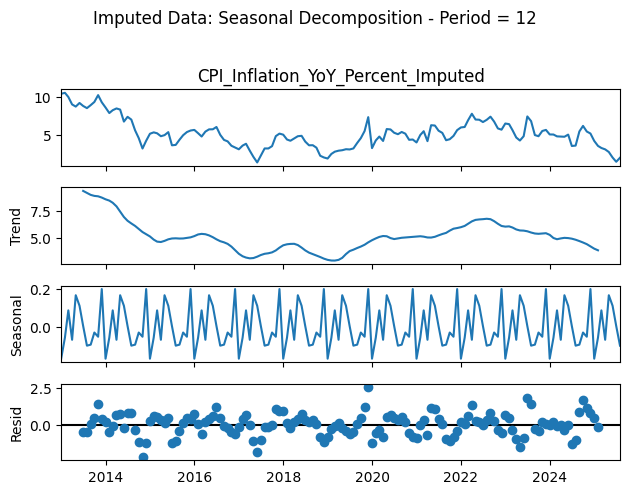

Hyndman Strength Score of Imputed Data: 0.0000
Low seasonality strength in data.


In [84]:
# Seasonal Decomposition
print('Seasonality decomposition and Hyndman Seasonality Strength Score')
seasonal_decompose_imputed = seasonal_decompose(
    df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'],
    model='additive',
    period=12
)
fig_imputed = seasonal_decompose_imputed.plot()
fig_imputed.suptitle('Imputed Data: Seasonal Decomposition - Period = 12',
                     fontsize=12,
                     y=1.02)
fig_imputed.tight_layout()
plt.show()

# Hyndman Strength Calculation
stl_imputed = STL(
    df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'],
    period=12,
    robust=True
).fit()
trend_imp, seasonality_imp, residual_imp = stl_imputed.trend, stl_imputed.seasonal, stl_imputed.resid
strength_imp = max(
    0, 
    (1 - (residual_imp.var()/(
        residual_imp.var()+seasonality_imp.var()+2*(residual_imp.cov(seasonality_imp))
        )))
    )
print(f'Hyndman Strength Score of Imputed Data: {strength_imp:.4f}')
if strength_imp >= 0 and strength_imp <= 0.3:
    print(f'Low seasonality strength in data.')
else:
    print(f'High seasonality strength in data.')

#### **Interpretation of STL analysis:**
As evidenced from the STL decomposition, the dataset demonstrates low seasonality, as indicated by the Hyndman Seasonality Strength Score. This means that seasonal differencing is not warranted. Additional ACF analysis and the subsequent CH test (presented in later sections) will provide confirmatory evidence regarding the presence or absence of seasonal unit roots.

#### **About ACF**
#### ACF: Autocorrelation Function
**ACF** measures linear correlation between a time series and **lagged** versions of itself. I.e., for lag $k$, it asks “how similar is $y_t$ to $y_{t-k}$?”

**How ACF works (high-level)**

In simple terms, ACF plots the correlation between the value of a series ($y_i$) at time $t$ and its value at time $t-k$ or $k$ periods earlier. The result (when applied across all data points in a series $Y$), gives us a graph that plots the correlations (vertical bars) between value of the series at time $t$ and value of the same series at time $t-k$ and the ±1.96/√n bands (shaded area). If this graph displays an oscillating pattern that shows significant spikes - repeating periodically (i.e. beyond the ±1.96/√n bands) - then we can conclude (with 95% confidence, if alpha = 5%) that seasonality is present in the raw data.

Below is a more detailed overview of ACF:

1. **Determine autocovariance**:
    For a weakly stationary series (i.e., a series of data whose mean $\mu$ and variance $\sigma^2$ do not change over time) $Y$, with mean $\mu$ and variance $\sigma^2$, determine the **autocovariance** at lag $k$, given as:

    $$
    \gamma(k) \;=\; \operatorname{Cov}(y_t,\; y_{t-k})
    \;=\; \mathbb{E}\!\big[(y_t-\mu)(y_{t-k}-\mu)\big].
    $$

    which measures the covariance between today’s value $y_t$ and the value $k$ time steps earlier ($y_{t-k}$).

2. **Determine autocorrelation**: 
    The **autocorrelation** at lag $k$ for the series $Y$ is then determined using:

    $$
    \rho(k) \;=\; \frac{\gamma(k)}{\gamma(0)} \;=\; \frac{\gamma(k)}{\sigma^2}.
    $$

    which normalizes the covariance (by the variance) so the result is a pure correlation coefficient (i.e., values lie between -1 and 1).

**ACF application in real data**:
Since, in the case of real data, we do not know the true mean or true expected values, we typically use the **sample ACF** method; given using the equation:

$$
\hat{\rho}(k)
\;=\;
\frac{\sum_{t=k+1}^{n}(y_t-\bar y)(y_{t-k}-\bar y)}
     {\sum_{t=1}^{n}(y_t-\bar y)^2},
$$

where $\bar y$ is the sample mean (which replaces the true mean) and $\sum$ is summation of the data (which replaces the expected values $\mathbb{E}$) 

**Interpretation of ACF:**
- **Seasonality:** Significant spikes at **seasonal lags** (e.g., $12, 24, 36,\dots$ for monthly data).
- **Trend / non-stationarity:** ACF that **decays slowly** (stays high for many lags) → likely non-stationary → difference first.
- If the ACF shows spikes at $12, 24, …$ → seasonal dynamics present (consider **SARIMA**).
- If ACF decays slowly → **difference (and possibly seasonal difference)**.

**Significance & confidence bands**
Under the null hypothesis of white noise (i.e., zero mean, constant variance, and no predictable pattern), approximate 95 % confidence bands are:  (Bartlett’s formula provides a more exact variance):
$$
\pm \frac{1.96}{\sqrt{n}},
$$
for each individual lag. Bartlett’s formula provides an exact variance for these bands.
For statistical significance, we can use **Ljung–Box** to jointly test “no autocorrelation up to lag $k$” where if p-value < chosen significance level (e.g. 0.05), we reject $H_o$ $\rightarrow$ to conclude that there is significant autocorrelation somewhere among the first $k$ lags.

#### **ACF Analysis:**

ACF plot of imputed data for visual assessment of seasonality


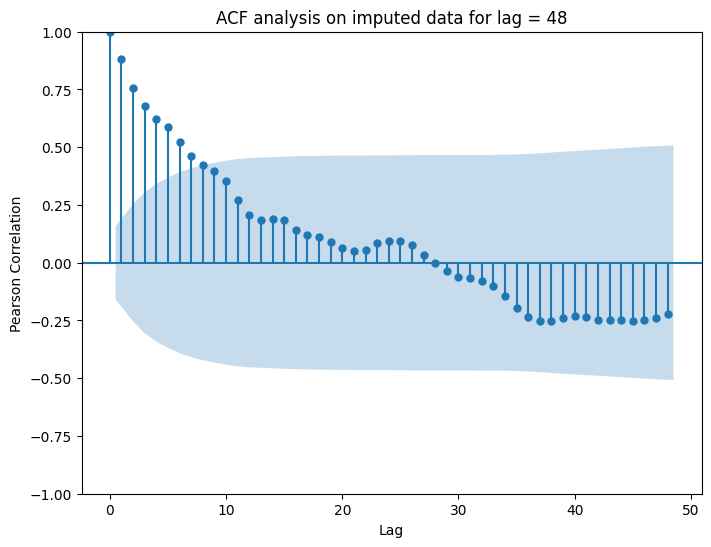

In [85]:
# ACF Plot of Imputed Data
print('ACF plot of imputed data for visual assessment of seasonality')
fig_imputed_acf, ax_imputed_acf = plt.subplots(figsize=(8 , 6), dpi=100)
plot_imputed_acf = plot_acf(
    df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'],
    lags=48,
    ax=ax_imputed_acf
)
ax_imputed_acf.set_title('ACF analysis on imputed data for lag = 48')
ax_imputed_acf.set_xlabel('Lag')
ax_imputed_acf.set_ylabel('Pearson Correlation')
plt.show()

#### **Interpretaion of ACF analysis:**

Consistent with the STL and Hyndman strength results, the ACF does not show pronounced spikes at seasonal lags (12, 24, 36, 48), indicating no strong seasonal pattern in the data. At the same time, the ACF exhibits a slow decay, which suggests strong persistence and is consistent with either a highly persistent AR process or possible non-stationarity in levels. The final Canova–Hansen test will specifically assess whether a seasonal unit root is present and hence whether seasonal differencing is warranted. Non-seasonal differencing (d) is motivated primarily by the persistence and slow decay in the ACF, whereas seasonal differencing (D) is guided by the CH test.

### **4.2. Final Seasonality Test - CH test**
This section uses the Canova-Hansen (CH) test to conclusively determine the presence of a seasonal unit root in the dataset. Based on the outcomes of this test, we will conclusively determine whether seasonal differencing is warranted.

#### **About CH:**
#### CH: Canova-Hansen Test
The **Canova–Hansen (CH)** test checks whether a time series contains a seasonal unit root—that is, whether a seasonal difference (e.g. a 12-month difference for monthly data) is needed to make the series stationary.

**Null ($H_0$) and Alternate ($H_1$) Hypothesis in CH Test**
- Null ($H_0$) Hypothesis: the series has a seasonal unit root $\rightarrow$ seasonal differencing needed - select SARIMA.
- Alternate ($H_1$) Hypothesis: the series does not contain a seasonal unit root $\rightarrow$ seasonal differencing not needed - proceed with ARIMA.

**Definition of Seasonal Root**

Presence of a seasonal unit root in a series means that seasonality in the dataset does not follow a repeating (osciallting) pattern. E.g., A monthly series whose January values have a mean that drifts over time rather than repeating around a constant seasonal mean.

**Practical Interpretation of Seasonal Root**

Presence of a seasonal unit root means that the data must be differenced at the seasonal lag to remove the stochastic seasonal component. After removing the seasonal component, the remaining series should be stationary and suitable for forecast modelling.

**How CH Test works**

In simple terms, a CH test performs a discrete Fourier Transform on seasonal regressons (sine, cosine pairs built on only the stochastic part of the dataset) called **Periodogram Ordinates** and takes a variance-weighted sum of these ordinates to determine the **Test Statistic**. The test statistic is then compared to critical values ($p_value$ < 0.05 or $p_value$ > 0.05) to determine the final decision on whether to accept or reject the **null hypothesis**.

#### **CH Test:**

In [86]:
# Cannova-Hansen Test for Seasonal Differencing
print('Cannova-Hansen test on imputed data to determine seasonal differencing:')
imputed_inflation_data = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'].astype('float64').to_numpy()
ch_imputed = CHTest(m=12)
D_imputed = ch_imputed.estimate_seasonal_differencing_term(imputed_inflation_data)
print('Result of Cannova-Hansen Test on Imputed Data:')
if D_imputed > 0.4:
    print(f'Estimated differencing value: {D_imputed:.4f}.')
else:
    print(f'Estimated differencing value: {D_imputed:.4f}.')

Cannova-Hansen test on imputed data to determine seasonal differencing:
Result of Cannova-Hansen Test on Imputed Data:
Estimated differencing value: 0.0000.


#### **Interpretaion of CH Test:**

Since the implementation of the Canova–Hansen test in pmdarima returns a test statistic but not p-values, we adopt a heuristic threshold of 0.4: values above 0.4 are treated as indicative of a seasonal unit root (suggesting that seasonal differencing is warranted, i.e., D = 1), whereas values below 0.4 suggest that seasonal differencing is not required (D = 0). In our dataset, the CH test returned a statistic of 0.0000, which is far below the threshold, indicating no evidence of a seasonal unit root. Therefore, seasonal differencing is not required.

## **Section 5: Identification of Exogenous Factors**
This section focuses on identifying a relationship between CPI Inflation and certain key exogenous factors. Augmenting ARIMA and SARIMA with exogenous factors have been known to improve overall model performance and hence, this notebook identifies the following 3 factors:

1. F&B inflation - Food and beverages make up ~46% of India's goods basket and hence, will play a major role in our model - Source:  
2. Brent crude prices - India imports 85% of its oil and hence, this factor will play a key role in modelling the inflation rate - Source: FRED (Federal Reserve Bank of St. Louis).
3. INR/USD exchange rate - India imports commodities, energy, machinery and hence any movement (aprpeciation/ depreciation) will play a key role in our model - Source: DBIE (Database on Indian Economy).
4. Repo (repurchase option) rate - RBI policy rate is a key determinant of demand-side inflation and hence, data on the same will also play a key role in our model - Source: MasterstrokeOnline (2013-23), 2024 rates extrapolated from 2023 (since no reported MPC meeting held) and 2025 rates taken from RBI press release.

To establish statistical significance between each factor and CPI Inflation Rate, we will perform a Pearson Correlation (to determine direction and strength of relationship) test between each of the 4 variables above and inflation.

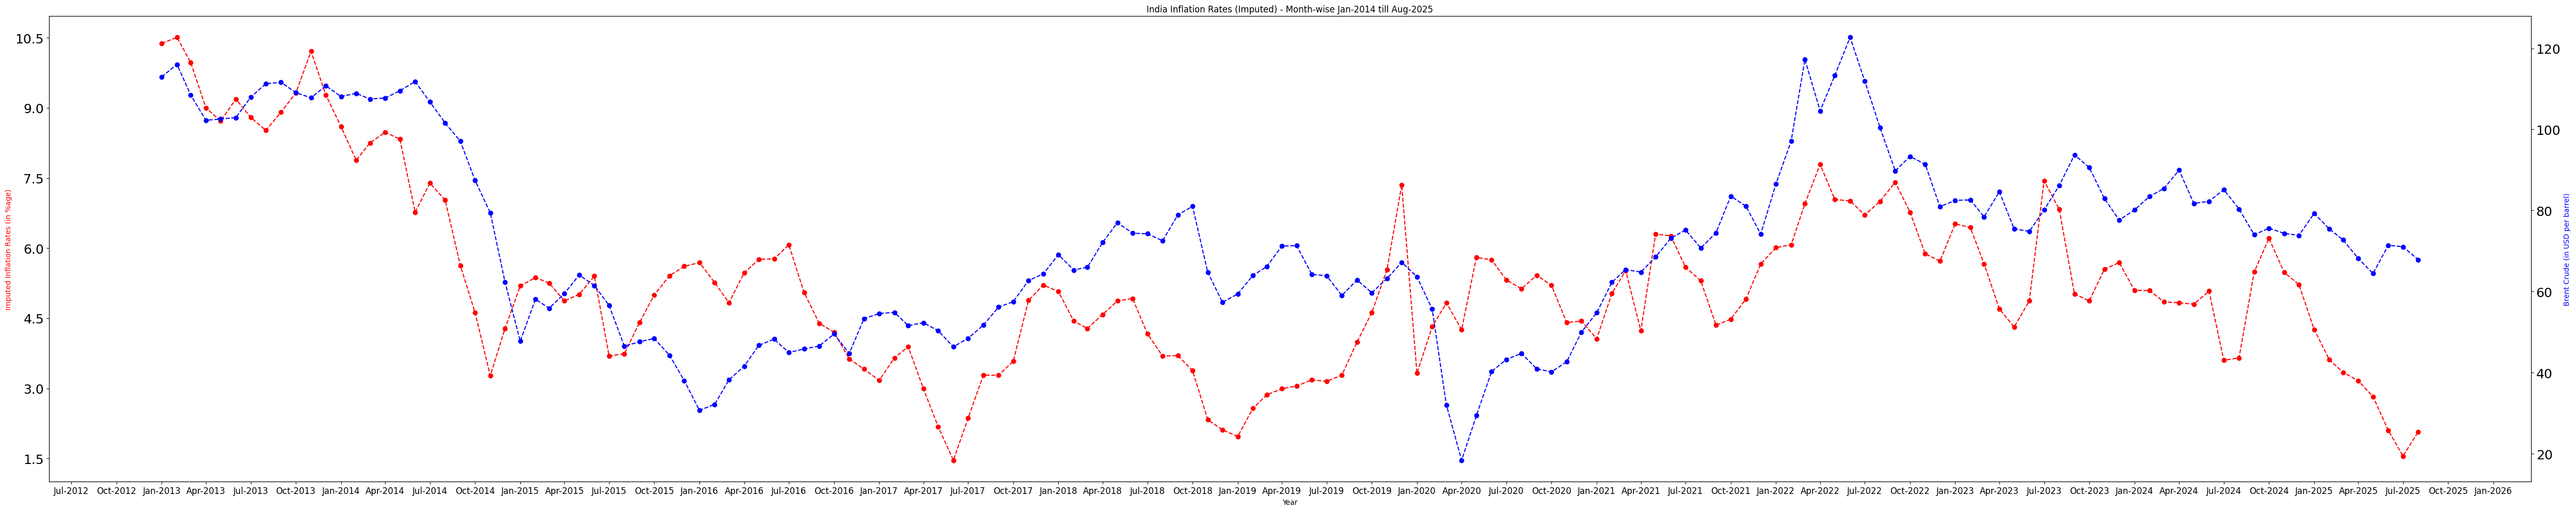

Pearson Correlation Between Brent Crude and Inflation
Correlation: 0.6314 and P-value: 0.0000
Medium to weak positive linear correlation between brent crude and inflation.
Stationarity Test (ADF) on Brent Crude Dataset - Trend Component:
Test results:
Test statistic: -2.6837744514126354
P-value: 0.07688832796667554
Number of observations: 150
Lags used: 1

ADF Test Conclusion:
Failed to Reject Ho: Series has a unit root - non-stationary. Trend differencing needed.
Stationarity Test (KPSS) on Brent Crude Dataset - Trend Component:
Test results:
Test statistic: 0.2276907449013167
P-value: 0.1
Lags used: 8

KPSS Test Conclusion:
Reject Ho: Series does not have a unit root - stationary. Trend differencing not needed.


In [87]:
# Load data
monthly_avg_brent_crude_2013_2025 = os.getenv('monthly_avg_brent_crude_2013_2025')
df_brent_crude = pd.read_csv(monthly_avg_brent_crude_2013_2025)
df_brent_crude['Period'] = pd.to_datetime(df_brent_crude['Period'])
df_brent_crude.set_index('Period', inplace=True)

# Plotting Brent Crude and Inflation Data
X_series = df_inflation_imputed.index
Y_series_inflation = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed']
Y_series_brent = df_brent_crude['USD_PER_BARREL']
fig, ax_inf = plt.subplots(figsize=(50, 10), dpi=100)
ax_inf.plot(X_series, Y_series_inflation, '--', color='red', marker='o', label='CPI_Inflation_YoY_Percent_Imputed')
ax_inf.set_title('India Inflation Rates (Imputed) - Month-wise Jan-2014 till Aug-2025')
ax_inf.set_xlabel('Year')
ax_inf.set_ylabel('Imputed Inflation Rates (in %age)', color='red')
ax_inf.set_xticks(X_series)
ax_inf.set_yticks(Y_series_inflation)
ax_inf.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax_inf.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax_inf.yaxis.set_major_locator(plt.MaxNLocator(8))
ax_inf.tick_params(axis='x', labelsize=12)
ax_inf.tick_params(axis='y', labelsize=18)
ax_brent = ax_inf.twinx()
ax_brent.plot(X_series, Y_series_brent, '--', color='blue', marker='o', label='Brent_Crude')
ax_brent.set_ylabel('Brent Crude (in USD per barrel)', color='blue')
ax_brent.tick_params(axis='y', labelsize=18)
fig.tight_layout()
plt.show()

# Pearson Correlation
print('=========================================================================')
print('Pearson Correlation Between Brent Crude and Inflation')
brent_inf_correl, brent_inf_p_value = pearsonr(df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'], df_brent_crude['USD_PER_BARREL'])
print(f'Correlation: {brent_inf_correl:.4f} and P-value: {brent_inf_p_value:.4f}')
if brent_inf_p_value < 0.05:
    if brent_inf_correl >= 0.70:
        print(f'Strong positive linear correlation between brent crude and inflation.')
    elif brent_inf_correl >= 0.10 and brent_inf_correl < 0.70:
        print(f'Medium to weak positive linear correlation between brent crude and inflation.')
    elif brent_inf_correl > -0.10 and brent_inf_correl < 0.10:
        print(f'No/ negligible linear correlation between brent crude and inflation.')
    elif brent_inf_correl > -0.70 and brent_inf_correl <= -0.10:
        print(f'Medium to weak negative linear correlation between brent crude and inflation.')
    elif brent_inf_correl <= -0.70:
        print(f'Strong negative linear correlation between brent crude and inflation.')

# Stationarity Test - Augmented Dickey Fuller
print('=========================================================================')
print('Stationarity Test (ADF) on Brent Crude Dataset - Trend Component:')
brent_adf_test_result = adfuller(df_brent_crude['USD_PER_BARREL'])
brent_adf_test_stat = brent_adf_test_result[0]
brent_adf_test_p_value = brent_adf_test_result[1]
brent_adf_test_lags_used = brent_adf_test_result[2]
brent_adf_test_obs = brent_adf_test_result[3]
print(f'Test results:')
print(f'Test statistic: {brent_adf_test_stat}')
print(f'P-value: {brent_adf_test_p_value}')
print(f'Number of observations: {brent_adf_test_obs}')
print(f'Lags used: {brent_adf_test_lags_used}')

print('\nADF Test Conclusion:')
if brent_adf_test_p_value > 0.05:
    print('Failed to Reject Ho: Series has a unit root - non-stationary. Trend differencing needed.')
else:
    print('Reject Ho: Series does not have a unit root - stationary. Trend differencing not needed.')

# Stationarity Test - KPSS
print('=========================================================================')
print('Stationarity Test (KPSS) on Brent Crude Dataset - Trend Component:')
brent_kpss_test_result = kpss(df_brent_crude['USD_PER_BARREL'])
brent_kpss_test_stat = brent_kpss_test_result[0]
brent_kpss_test_p_value = brent_kpss_test_result[1]
brent_kpss_test_lags_used = brent_kpss_test_result[2]
brent_kpss_test_obs = brent_kpss_test_result[3]
print(f'Test results:')
print(f'Test statistic: {brent_kpss_test_stat}')
print(f'P-value: {brent_kpss_test_p_value}')
print(f'Lags used: {brent_kpss_test_lags_used}')

print('\nKPSS Test Conclusion:')
if brent_kpss_test_p_value > 0.05:
    print('Reject Ho: Series does not have a unit root - stationary. Trend differencing not needed.')
else:
    print('Failed to Reject Ho: Series has a unit root - non-stationary. Trend differencing needed.')

## **Section 6: 5-year Forecast**

Having conducted all diagnostic tests, we have arrived to the conclusion that seasonal differencing is not warranted. This means that ARIMA will be sufficient in describing and forecasting the data. However, since our objective is to evaluate performance of the three models (ARIMA, SARIMA and XGBoost) and not generate forecasts for economic/ financial use, we shall still use SARIMA on the data to observe results across the established parameters.

### **6.1. ARIMA (Autoregressive Integrated Moving Average) and ARIMAX (ARIMA with Exogenous Variables)**

#### **About ARIMA:**

ARIMA is a time-series forecasting model. A model is called a time-series model when it satisfies the following three conditions:

- The model explicitly depends on time ordering - i.e., the model uses past values to predict future outcomes.
- The model captures temporal dependence - i.e., patterns such as persistence, autocorrelation and seasonality are central to how the model learns.
- The model forecasts future values by extrapolating time-based relationships.

ARIMA does not directly forecast the level of a variable. It first makes the data stationary (i.e., stabilizes the mean and variance of the data) by differencing the value in the current period from the value in the past period (e.g. if inflation in Jan-15 is 4.5% and inflation in Dec-14 is 4.2%, ARIMA will first capture the rate of change for the period (a.k.a discrete differencing) i.e. 0.3%. This is done by the "Integrated (I)" component of the model). Making the data stationary essentially removes the trend from the data and the reason why this is done is because the math behind AutoRegressive (AR) and Moving Average (MA) components assume that the data they are applied on is stationary. If not, AR and MA will generate error-prone results. Once the data has been made stationary, the AR and MA components apply the linear stochastic equation ("stochastic" since the error and intercept parameters are random variables determined using Maximum Likelihood Estimation) to forecast the change (not the actual inflation value but only the change). The forecasted change is then added to the last known value of inflation to determine the predicted inflation values (thereby incorporating the trend that was originally removed during the integrated stage).

**Additional Note - Difference between ARIMA and SARIMA:** In the above explanation of the ARIMA model we subtracted Dec-14 from Jan-15 to get the rate of change. Had our data demonstrated a seasonal root, and we would have used the SARIMA model - instead of ARIMA, this differencing would be Jan-14 from Jan-15 - to account for seasonality in the data. Thus, the fundamental difference between ARIMA and SARIMA is how seasonality is accounted for. Where in ARIMA the differencing is month-on-month (i.e., $Y_t - Y_{t-1}$), in SARIMA the differencing is done on a year-on-year basis (i.e., $Y_t - Y_{t-12}$).

The ARIMA model comprises of three components:

1. **AR (AutoRegressive):** This component of the model uses linear stochastic regression to model the predicted value as a linear combination of its past values. This component is determined using **p** in the ARIMA model input.
    - **Equation:**
        $$
        Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \varepsilon_t
        $$
        where:
        
        $Y_t$ = current value (e.g., inflation at time t)
        
        $c$ = constant (intercept) - determined using MLE (Maximum Likelihood Estimation)
        
        $\phi_i$ = autoregressive coefficient - determined using MLE.
        
        $\varepsilon_t$ = white noise (random error)

2. **I (Integrated):** This component of the model stabilizes the mean and variance of the differences - thereby making the data stationary for AR and MA components to be applied for forecasting. This component is determined using **d** in the ARIMA model input.
    - **Equation:**
        
        If d = 1 - used when the data demonstrates a linear trend
        $$
        \nabla Y_t = Y_t - Y_{t-1}
        $$
        where:
        
        $Y_t$ = current value (e.g., inflation at time t)
        
        $Y_{t-1}$ = previous month value (e.g., inflation at time t-1)
        
        If d = 2 - used when the data demonstrates a quadratic (or exponential-like) trend
        $$
        \nabla^2 Y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) = Y_t - 2Y_{t-1} + Y_{t-2}
        $$
        where:
        
        $Y_t$ = current value (e.g., inflation at time t)
        
        $Y_{t-1}$ = previous month value (e.g., inflation at time t-1)

3. **MA (Moving Average):** This component of the model also uses linear stochastic regression but for modelling the error of the predicted value as a linear combination of its past errors. This component is determined using **q** in the ARIMA model input.
    - **Equation:**
        $$
        Y_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q}
        $$
        where:
        
        $\varepsilon_t$ = white noise error - residual term - results from $c$ and  $\theta_i$
        
        $c$ = constant (intercept) - determined using MLE

        $\theta_i$ = Moving average coefficients (capturing impact of past shocks) - determined using MLE


**How it all comes together:** 

All three components explained above come together to make up the final ARIMA(p=1, d=1, q=1) equation given as follows:

$$
\nabla Y_t = c + \phi_1 (\nabla Y_{t-1}) + \varepsilon_t + \theta_1 \varepsilon_{t-1}
$$

where:

$c$ = constant (intercept) - determined using MLE

$\varepsilon_t$ = white noise error - residual term - results from $c$, $\theta_i$ and $\phi_i$

$\theta_i$ = Moving average coefficients (capturing impact of past shocks) - determined using MLE

$\phi_i$ = autoregressive coefficient - determined using MLE.


Data preparation, model training and presentation of in-sample, out-of-sample and forecast results:
Imputed Data RMSE - ARIMA: 1.9080528987779188
Imputed Data MAE - ARIMA: 1.6928889557728475
ARIMA performance on out-of-sample parameters:


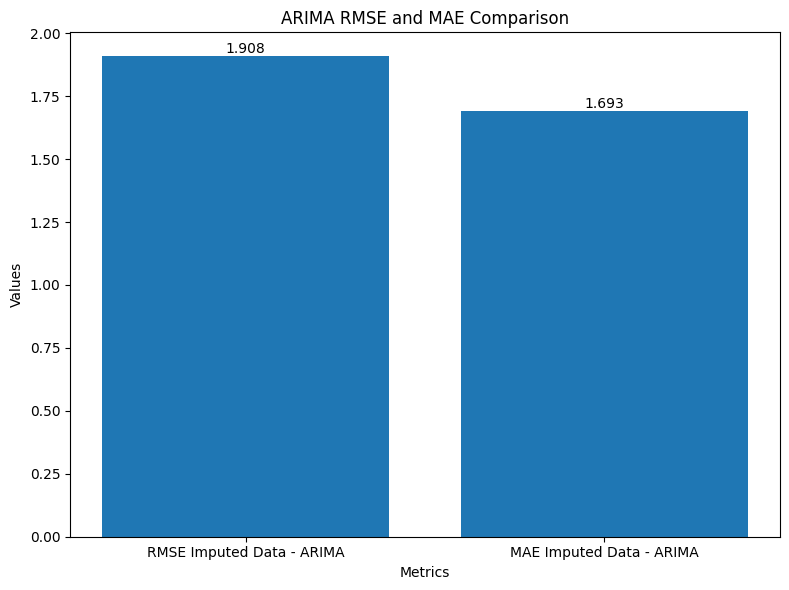

As evident from the plot above, imputing the data for periods of 2020 and 2021 reduced both RMSE and MAE errors.
Summary Statistics:
                                       SARIMAX Results                                       
Dep. Variable:     CPI_Inflation_YoY_Percent_Imputed   No. Observations:                  140
Model:                                ARIMA(1, 0, 1)   Log Likelihood                -164.163
Date:                               Sat, 29 Nov 2025   AIC                            336.327
Time:                                       10:14:01   BIC                            348.093
Sample:                                   01-01-2013   HQIC                           341.108
                                        - 08-01-2024                                         
Covariance Type:                              robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

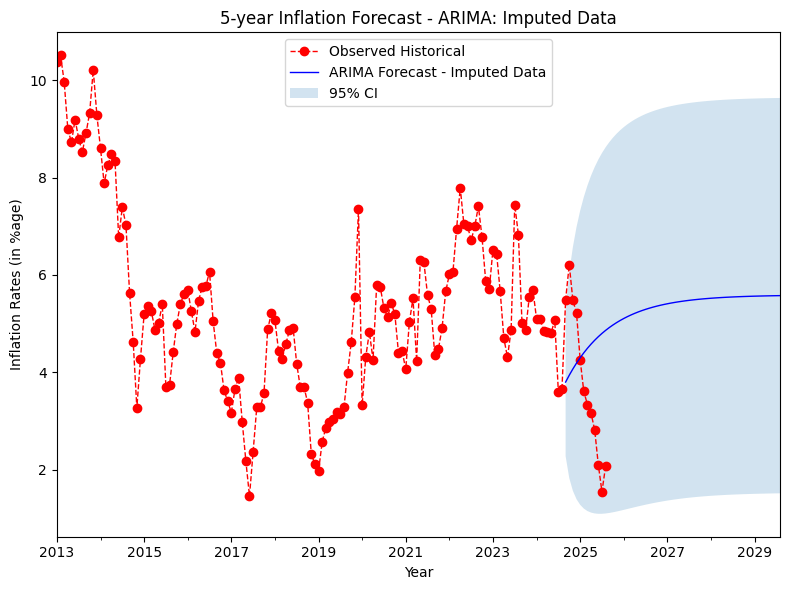

In [88]:
# Training the ARIMA model on Imputed Data and Calculating Errors
print('Data preparation, model training and presentation of in-sample, out-of-sample and forecast results:')
model_arima_imputed = ARIMA(train_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], order=(1, 0, 1)).fit(cov_type='robust')
model_arima_imputed_pred = model_arima_imputed.get_forecast(steps=12).predicted_mean
model_arima_imputed_rmse = root_mean_squared_error(test_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], model_arima_imputed_pred)
model_arima_imputed_mae = mean_absolute_error(test_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], model_arima_imputed_pred)
print(f'Imputed Data RMSE - ARIMA: {model_arima_imputed_rmse}')
print(f'Imputed Data MAE - ARIMA: {model_arima_imputed_mae}')
print('ARIMA performance on out-of-sample parameters:')
Y_comp_values = [model_arima_imputed_rmse, model_arima_imputed_mae]
X_comp_values = ['RMSE Imputed Data - ARIMA', 'MAE Imputed Data - ARIMA']
plt.subplots(figsize=(8, 6), dpi=100)
bars = plt.bar(X_comp_values, Y_comp_values)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('ARIMA RMSE and MAE Comparison', fontsize=12)
plt.tight_layout()
plt.show()
print(f'As evident from the plot above, imputing the data for periods of 2020 and 2021 reduced both RMSE and MAE errors.')
print(f'Summary Statistics:\n{model_arima_imputed.summary()}')
imp_is_stationary = np.all(np.abs(model_arima_imputed.arroots) > 1)
imp_is_invertible = np.all(np.abs(model_arima_imputed.maroots) > 1)
print(f'Stability result: {imp_is_stationary}')
print(f'Invertability result: {imp_is_invertible}')

# Generating Forecast Based on Imputed Data.
print('====================================================================')
print('Generating 5-year forecast based on imputed dataset:')
model_arima_imputed_forecast = model_arima_imputed.get_forecast(steps=60)
model_arima_imputed_forecast_summary = model_arima_imputed_forecast.summary_frame(alpha=0.05)
df_prediction_data_imp = model_arima_imputed_forecast_summary[['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']]
df_prediction_data_imp.index.name = 'Period'
df_prediction_data_imp.to_csv(forecast_imputed_dataset)
model_arima_imputed_forecast.index = pd.to_datetime(model_arima_imputed_forecast_summary.index, errors='coerce')
fig_forecast_imp, ax_forecast_imp = plt.subplots(figsize=(8, 6), dpi=100)
df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'].plot(ax=ax_forecast_imp, label='Observed Historical', 
                lw=1, color='red', 
                linestyle='--', marker='o')
model_arima_imputed_forecast_summary['mean'].plot(ax=ax_forecast_imp, 
                             label='ARIMA Forecast - Imputed Data', 
                             lw=1, 
                             color='blue')
ax_forecast_imp.fill_between(model_arima_imputed_forecast_summary.index, 
                             model_arima_imputed_forecast_summary['mean_ci_lower'], 
                             model_arima_imputed_forecast_summary['mean_ci_upper'], 
                             alpha=0.2, 
                             label='95% CI')
ax_forecast_imp.set_xlabel('Year')
ax_forecast_imp.set_ylabel('Inflation Rates (in %age)')
ax_forecast_imp.set_title('5-year Inflation Forecast - ARIMA: Imputed Data')
ax_forecast_imp.legend()
plt.tight_layout()
plt.show()

**FINDINGS:**

1. **$p=1, d=1, q=1$:** log-likelihood = -162, AIC = 330, BIC = 339.
2. Out-of-Sample performance of ARIMA: RMSE = 1.59 and MAE = 1.42
3. p-values "Statistical Significance" of both AR and MA coefficients - meaning that the estimated model coefficients (AR and MA only) contribute towards explaining variability in the data.
4. The Ljung-Box test p-value (0.56 > 0.05) indicates that the model residuals exhibit no statistically significant autocorrelation, suggesting that the ARIMA model has adequately captured the dependence structure.


**Key Takeaway:** Even with statistical significance, the model DOES NOT generate long-run economically viable forecasts (with 2025-26FY projections circulating around 4.13% while RBI forecasts the same to be 2.6%). The low economic viability of ARIMA could be attributed to the short, low-volatility and mean reverting regime that the underlying dataset is exposed to. This makes the model is succeptible to:

 - Low volatility
 - No upward trend
 - No structural shocks
 - No strong seasonality


### **6.2. SARIMA (Seasonal Autoregressive Integrated Moving Average)**

This section focuses on fitting a SARIMA model to observe changes to RMSE, MAE, Log-Likelihood, AIC and BIC outcomes. While seasonality strength tests have conclusively established that SARIMA is not warranted for this dataset, we will still proceed to test the data with SARIMA to observe changes to both in-sample and out-of-sample values to gauge how strong/weak/constant SARIMA performs - when compared to ARIMA. Since seasonality tests have already been performed on the imputed data in the above section, we shall not repeat the same here.

SARIMA extends ARIMA by incorporating seasonal components — specifically, seasonal differencing, seasonal autoregressive terms, and seasonal moving-average terms. While ARIMA captures short-run temporal dependence through AR, MA, and differencing terms, SARIMA additionally models recurring seasonal patterns using 
$s$-period lags (e.g., $Y_t - Y(t-12)$). Seasonal differencing ($Y_t - Y(t-s)$) is applied only when the data shows statistically significant seasonality. Therefore, while based on our tests for seasonality strength tests, we do not expect SARIMA to inherently perform better than ARIMA; the purpose of this section is to empirically test this hypothesis and determine whether incorporating seasonal structure improves the model’s in-sample fit and out-of-sample forecasting accuracy for this dataset.

#### **About SARIMA:**

SARIMA (Seasonal AutoRegressive Integrated Moving Average) is an extension of ARIMA used when the time-series exhibits both trend and seasonality. A model is considered a seasonal time-series model when it satisfies the following three conditions:

- The model explicitly depends on time ordering – i.e., the model uses past values to predict future outcomes.
- The model captures temporal dependence – i.e., persistence, autocorrelation, and recurring seasonal patterns (e.g., yearly cycles for monthly data).
- The model forecasts future values by extrapolating both non-seasonal and seasonal time-based relationships.

Just like ARIMA, SARIMA does not directly forecast the level of a variable. It first makes the data stationary by removing trend (non-seasonal differencing) and then removes seasonality (seasonal differencing). Once stationarity is achieved, the AR, MA, SAR (Seasonal AutoRegressive), and SMA (Seasonal Moving Average) components model the pattern of changes. These predicted changes are then added to the most recent actual value to produce forecasts.

**Additional Note – Difference between ARIMA and SARIMA:** In ARIMA, differencing removes trend using month-on-month changes (i.e., $Y_t - Y_{t-1}$). In SARIMA, an additional seasonal differencing is applied using values from the same season in the previous year (i.e., $Y_t - Y_{t-12}$ for monthly data). Thus, SARIMA accounts for recurring seasonal structure on top of ARIMA.


**The SARIMA model comprises six components (3 non-seasonal + 3 seasonal):**



##### **1. AR (AutoRegressive – Non-seasonal):**  
This component uses linear stochastic regression to model the predicted value as a linear combination of its past non-seasonal values. This component is determined using **p** in the SARIMA model input.

 - **Equation:**
    $$
    Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \varepsilon_t
    $$

    where:

    $Y_t$ = current value (e.g., inflation at time t)

    $c$ = constant (intercept) – determined using MLE

    $\phi_i$ = autoregressive coefficients – determined using MLE

    $\varepsilon_t$ = white noise (random error)



##### **2. I (Integrated – Non-seasonal):**  
This component removes non-seasonal trend from the data and makes the series stationary. It is determined using **d** in the SARIMA model input.

 - **Conditions:**
    
    If $d = 1$ (linear trend):

    $$
    \nabla Y_t = Y_t - Y_{t-1}
    $$

    If $d = 2$ (quadratic trend):

    $$
    \nabla^2 Y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) = Y_t - 2Y_{t-1} + Y_{t-2}
    $$

    where:

    $Y_t$ = current value  
    $Y_{t-1}$, $Y_{t-2}$ = previous values



##### **3. MA (Moving Average – Non-seasonal):**  
This component models the predicted value as a linear combination of past non-seasonal errors. It is determined using **q** in the SARIMA model input.

 - **Equation:**
    $$
    Y_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q}
    $$

    where:

    $\varepsilon_t$ = white noise error

    $c$ = constant (intercept)

    $\theta_i$ = moving average coefficients – determined using MLE



##### **Seasonal Components (Applied at lag $s$, e.g., $s = 12$ for monthly data):**



##### **4. SAR (Seasonal AutoRegressive):**  
This component models the predicted value using past values from the same season in previous cycles. It is determined using **P** in the SARIMA model input.

 - **Equation:**
    $$
    Y_t = c + \Phi_1 Y_{t-s} + \Phi_2 Y_{t-2s} + \dots + \Phi_P Y_{t-Ps} + \varepsilon_t
    $$

    where:

    $s$ = seasonal period (e.g., 12)

    $\Phi_i$ = seasonal autoregressive coefficients



##### **5. SI (Seasonal Integrated – Seasonal differencing):**  
This component removes seasonal patterns by differencing at lag $s$. It is determined using **D** in the SARIMA model input.

 - **Conditions:**
    
    If $D = 1$:

    $$
    \nabla_s Y_t = Y_t - Y_{t-s}
    $$

    If $D = 2$:

    $$
    \nabla_s^2 Y_t = (Y_t - Y_{t-s}) - (Y_{t-s} - Y_{t-2s}) 
                = Y_t - 2Y_{t-s} + Y_{t-2s}
    $$

    where:

    $s$ = seasonal period  
    $Y_{t-s}$, $Y_{t-2s}$ = seasonal lagged values



##### **6. SMA (Seasonal Moving Average):**  
This component models the predicted value as a combination of past seasonal shocks (errors spaced $s$ periods apart). It is determined using **Q**.

 - **Equation:**
    $$
    Y_t = c + \varepsilon_t + \Theta_1 \varepsilon_{t-s} + \Theta_2 \varepsilon_{t-2s} + \dots + \Theta_Q \varepsilon_{t-Qs}
    $$

    where:

    $\Theta_i$ = seasonal moving average coefficients – determined using MLE



##### **How it all comes together:**  

A SARIMA model is written as:

$$
SARIMA(p,d,q)(P,D,Q)_s
$$

After applying both non-seasonal differencing ($\nabla$) and seasonal differencing ($\nabla_s$), the combined model becomes:

$$
\nabla^d \nabla_s^D Y_t
= c 
+ \phi_1 (\nabla^d \nabla_s^D Y_{t-1})
+ \Phi_1 (\nabla^d \nabla_s^D Y_{t-s})
+ \varepsilon_t
+ \theta_1 \varepsilon_{t-1}
+ \Theta_1 \varepsilon_{t-s}
$$

where:

$c$ = constant (intercept) – determined using MLE  
$\phi_i$ = autoregressive coefficients  
$\theta_i$ = moving average coefficients  
$\Phi_i$ = seasonal autoregressive coefficients  
$\Theta_i$ = seasonal moving average coefficients  
$\varepsilon_t$ = white noise error  

This structure allows SARIMA to capture trend, irregular variation, and recurring seasonal cycles in a unified model.


Model training and comparison with ARIMA:
Imputed Data RMSE - SARIMA: 1.3416350995208692
Imputed Data MAE - SARIMA: 1.0769067518699087
SARIMA performance on out-of-sample parameters and comparison with ARIMA:


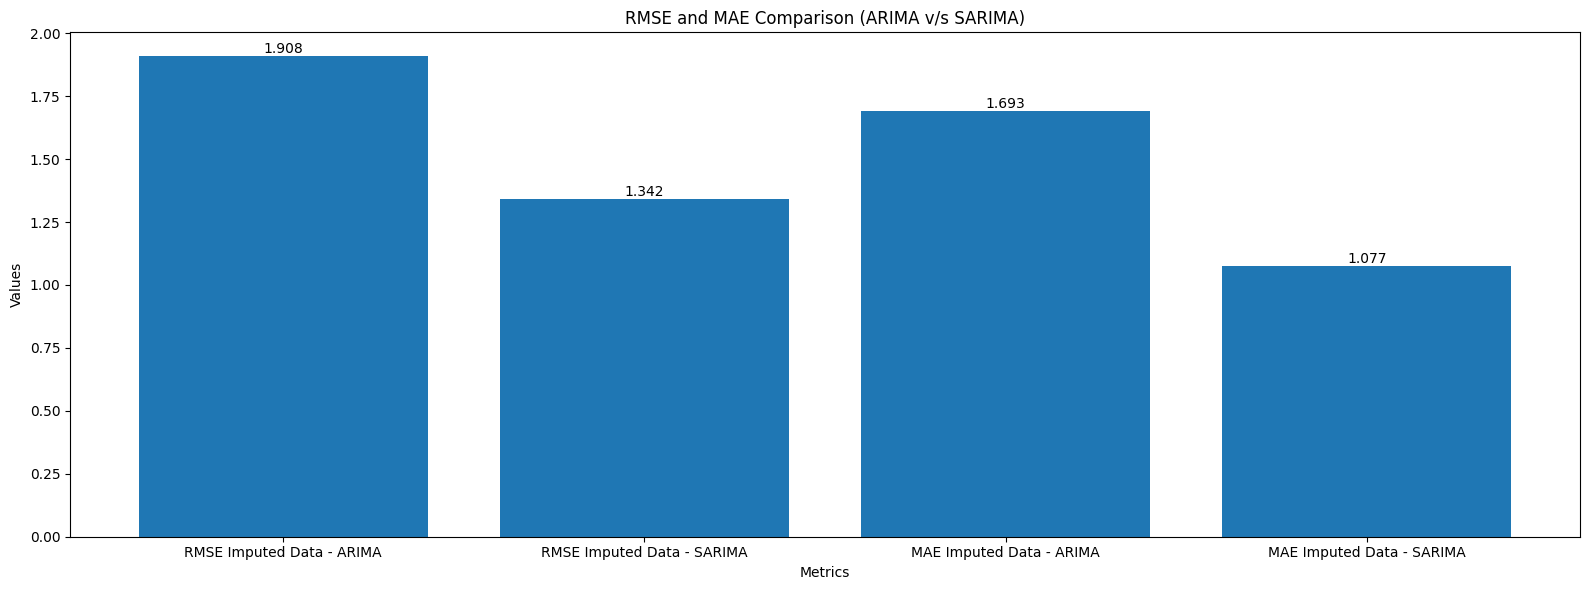

Summary Statistics:
                                       SARIMAX Results                                       
Dep. Variable:     CPI_Inflation_YoY_Percent_Imputed   No. Observations:                  140
Model:                SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -140.326
Date:                               Sat, 29 Nov 2025   AIC                            290.653
Time:                                       10:14:02   BIC                            304.834
Sample:                                   01-01-2013   HQIC                           296.414
                                        - 08-01-2024                                         
Covariance Type:                              robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9852      0.007    137.707      0.000       0.971    

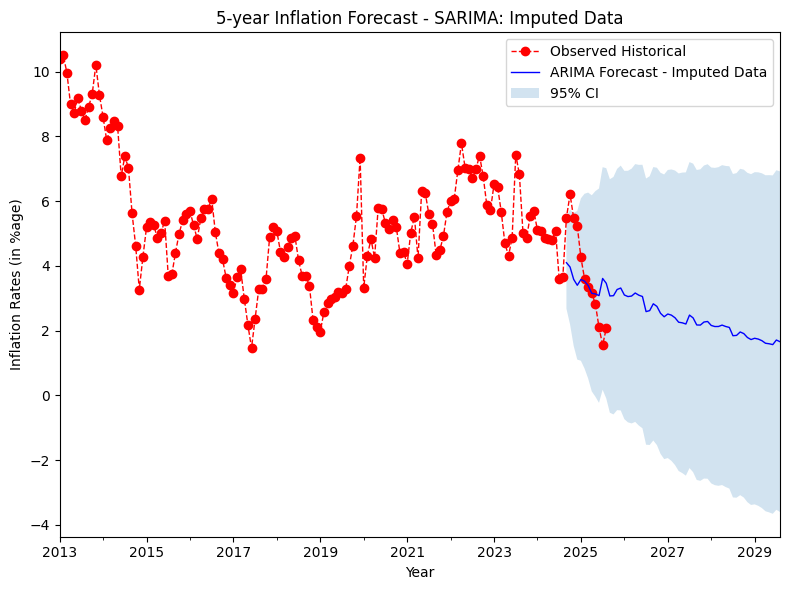

In [89]:
# Training SARIMA model on Imputed Data and Calculating Errors
print('Model training and comparison with ARIMA:')
model_sarima_imputed = SARIMAX(
    train_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], 
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_invertibility=False,
    enforce_stationarity=False
).fit(cov_type='robust')
model_sarima_imputed_pred = model_sarima_imputed.get_forecast(steps=12).predicted_mean
model_sarima_imputed_rmse = root_mean_squared_error(test_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], model_sarima_imputed_pred) 
model_sarima_imputed_mae = mean_absolute_error(test_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], model_sarima_imputed_pred) 
print(f'Imputed Data RMSE - SARIMA: {model_sarima_imputed_rmse}')
print(f'Imputed Data MAE - SARIMA: {model_sarima_imputed_mae}')
print('SARIMA performance on out-of-sample parameters and comparison with ARIMA:')
Y_comp_values_SARIMA = [model_arima_imputed_rmse, model_sarima_imputed_rmse, model_arima_imputed_mae, model_sarima_imputed_mae]
X_comp_values_SARIMA = ['RMSE Imputed Data - ARIMA', 'RMSE Imputed Data - SARIMA', 'MAE Imputed Data - ARIMA', 'MAE Imputed Data - SARIMA']
plt.subplots(figsize=(16, 6), dpi=100)
bars = plt.bar(X_comp_values_SARIMA, Y_comp_values_SARIMA)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center', 
        va='bottom',
        fontsize=10
    )
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RMSE and MAE Comparison (ARIMA v/s SARIMA)', fontsize=12)
plt.tight_layout()
plt.show()
print(f'Summary Statistics:\n{model_sarima_imputed.summary()}')

# Generating Forecast Based on Imputed Data.
print('====================================================================')
print('Generating 5-year forecast based on imputed dataset:')
model_sarima_imputed_forecast = model_sarima_imputed.get_forecast(steps=60)
model_sarima_imputed_forecast_summary = model_sarima_imputed_forecast.summary_frame(alpha=0.05)
df_prediction_data_sarima_imp = model_sarima_imputed_forecast_summary[['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']]
df_prediction_data_sarima_imp.index.name = 'Period'
df_prediction_data_sarima_imp.to_csv(sarima_forecast_imputed_dataset)
model_sarima_imputed_forecast_summary.index = pd.to_datetime(model_sarima_imputed_forecast_summary.index, errors='coerce')
fig_forecast_imp, ax_forecast_imp = plt.subplots(figsize=(8, 6), dpi=100)
df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'].plot(ax=ax_forecast_imp, label='Observed Historical', 
                lw=1, color='red', 
                linestyle='--', marker='o')
model_sarima_imputed_forecast_summary['mean'].plot(ax=ax_forecast_imp, 
                             label='ARIMA Forecast - Imputed Data', 
                             lw=1, 
                             color='blue')
ax_forecast_imp.fill_between(model_sarima_imputed_forecast_summary.index, 
                             model_sarima_imputed_forecast_summary['mean_ci_lower'], 
                             model_sarima_imputed_forecast_summary['mean_ci_upper'], 
                             alpha=0.2, 
                             label='95% CI')
ax_forecast_imp.set_xlabel('Year')
ax_forecast_imp.set_ylabel('Inflation Rates (in %age)')
ax_forecast_imp.set_title('5-year Inflation Forecast - SARIMA: Imputed Data')
ax_forecast_imp.legend()
plt.tight_layout()
plt.show()

**FINDINGS:**

1. **$p=1, d=1, q=1, P=1, D=1, Q=1, s=12$:** log-likelihood = -142(higher than ARIMA), AIC = 295, BIC = 308 (both lower than ARIMA).
2. Out-of-Sample performance of ARIMA: RMSE = 1.90 and MAE = 1.68 (much higher than ARIMA).
3. p-values "Statistical Significance" of AR, MA and Seasonal AR coefficients - meaning that out of all estimated model coefficients, only AR, MA and Seasonal AR contribute towards explaining variability in the data.
4. The Ljung-Box test p-value (0.77 > 0.05) indicates that the model residuals exhibit no statistically significant autocorrelation, suggesting that the ARIMA model has adequately captured the dependence structure.

**Key Takeaway:** Although all diagnostics suggested that SARIMA is not warranted for the dataset, the model's in-sample performance is slightly better than ARIMA. However, in contrast, the model performs substantially lower than ARIMA on out-of-sample tests. On economic viability of the model forecast, SARIMA output does not generate significantly better results (with 2025-26FY projections circulating around 4.5% while RBI forecasts the same to be 2.6%). Similar to ARIMA, this again could be attributed to the underlying dataset.

### **6.3. XGBoost - Extreme Gradient Boosting (with imputed data) - CUDA Enabled**

This section focuses on fitting an XGBoost model (using imputed data for 2020 and 2021 periods) to observe changes to RMSE, MAE and long-run macro-economic forecast. XGBoost is a supervised, non-parametric, tree-ensemble model that often outperforms traditional statistical models due to its inherent ability to capture non-linear relationships, high-order interactions, structural breaks, and irregular dynamics without requiring assumptions of linearity, stationarity, or Gaussian errors. Since XGBoost does not optimize a likelihood-based objective, classical statistical metrics such as Log-Likelihood, AIC, and BIC are not applicable. Instead, the focus is on comparing out-of-sample forecasting accuracy (RMSE and MAE), model stability, and long-run forecast viability—relative to ARIMA and SARIMA.

In this section, we will test this assumption and provide empirical evidence to support (if true) or explain (if untrue) this expectation.

Additionally, to enable faster processing, XGBoost has been executed in a WSL (Windows Subsystem for Linux) environment which is CUDA (Compute Unified Device Architecture) enabled and allows XGBoost to leverage the power of a discrete GPU (via NVIDIA's CUDA framework) and reduce the model's training time - compared to a CPU-only environment.

#### **About XGBoost:**

XGBoost (Extreme Gradient Boosting) is an implementation of gradient-boosted decision trees. It builds an ensemble of weak learners (regression trees), where each successive tree attempts to correct the residual errors made by the previous ensemble.

A model is considered a machine-learning ensemble model (such as XGBoost) when it satisfies the following three conditions:

- The model does **not** rely on explicit time ordering assumptions or differencing rules; instead, time dependence is learned implicitly through lagged feature inputs.
- The model captures **non-linear and interaction effects**, including threshold effects, saturation effects, and regime changes.
- The model forecasts future values by iteratively minimizing a loss function through gradient boosting, rather than by extrapolating parametric temporal relationships.

##### **Key Points of Note on XGBoost:**

- XGBoost grows trees using a **depth-first, leaf-wise strategy**, where the algorithm always expands the leaf with the highest Gain value. This contrasts with breadth-first tree growth in classical CART-style algorithms, which split all nodes at the same depth before moving deeper.
- XGBoost uses depth-first growth because **leaf-wise expansion maximizes loss reduction at each step**. The algorithm greedily chooses the split that provides the largest improvement in the objective, which often occurs deeper in the tree. This produces more flexible and expressive trees, although it may increase computation compared to the simpler breadth-first splitting used in CART.
- Unlike bagging algorithms - which require samples to be generated (using SRSWR) for parallel processing - boosting algorithms do not have any such requirements. Additionally, it is recommended to **NOT** perform any sampling when using XGBoost on time-series data and instead, maintain strict chronological order - to avoid data leakage.

##### **XGBoost Prediction Structure:**

Unlike ARIMA/SARIMA, XGBoost does not use AR, MA, SAR, SMA, or differencing operators. Instead, its predictions follow:

$$
\hat{Y}_t = \sum_{k=1}^{K} f_k(X_t), \qquad f_k \in \mathcal{F}
$$

where:

- $X_t$ = feature vector at time $t$ (e.g., lag values: $Y_{t-1}, Y_{t-2}, \dots$)
- $K$ = number of boosted trees
- $f_k$ = kth regression tree in the model (weak learner)
- $\mathcal{F}$ = space of all possible trees


The model is trained by minimizing a regularized objective:

$$
\mathcal{L} = \sum_{t=1}^{T} \ell \left( Y_t, \hat{Y}_t \right)
\; + \;
\sum_{k=1}^{K} \Omega(f_k)
$$

where the objective includes:

1. a **training loss** term $\ell(\cdot)$, and  
2. a **regularization** term $\Omega(f_k)$ controlling model complexity.

To optimize this objective efficiently, XGBoost applies a second-order Taylor expansion of the loss around $\hat{Y}_t^{(k-1)}$.

##### **Key Components of XGBoost:**

**1. Ensemble of Regression Trees:**  
Each tree partitions the feature space into regions and assigns a constant value to each region. Trees capture **non-linearities** and **interaction effects** that linear time-series models cannot model.

**2. Gradient Boosting Mechanism:**  
Each tree $f_k$ partitions the feature space into $T_k$ leaf regions and assigns a constant value to each leaf.  
This enables the model to capture:

- non-linear relationships  
- threshold effects  
- interactions between lagged predictors  

that cannot be modeled using linear time-series techniques.

**2. Gradient Boosting Mechanism (Conceptual Layer):**

Classical gradient boosting fits each new tree to the **negative gradient** of the loss function evaluated at the previous prediction:

$$
g_t 
= 
\frac{\partial \ell(Y_t,\; \hat{Y}_t^{(k-1)})}{\partial \hat{Y}_t^{(k-1)}}
$$

Once $f_k$ is learned, the model prediction is updated as:

$$
\hat{Y}_t^{(k)}
=
\hat{Y}_t^{(k-1)}
+
\eta \; f_k(X_t)
$$

where:

- $\eta$ = learning rate  
- a smaller $\eta$ reduces overfitting through conservative updates  

**3. Second-Order Optimization (Actual XGBoost Implementation):**

XGBoost improves on classical gradient boosting by incorporating **second-order information**.  
A second-order Taylor expansion of the loss yields:

$$
\ell(Y_t,\; \hat{Y}_t^{(k-1)} + f_k(X_t))
\approx
\ell(Y_t,\; \hat{Y}_t^{(k-1)})
+
g_t f_k(X_t)
+
\frac{1}{2} h_t f_k(X_t)^2
$$

where:

- $g_t = \frac{\partial \ell}{\partial \hat{Y}_t}$ is the first derivative (gradient)  
- $h_t = \frac{\partial^2 \ell}{\partial \hat{Y}_t^2}$ is the second derivative (Hessian)  

Let the set of samples belonging to leaf $j$ be indexed by $t \in j$.  
Define:

$$
G_j = \sum_{t \in j} g_t,
\qquad
H_j = \sum_{t \in j} h_t
$$

Using this local quadratic approximation, XGBoost obtains the **optimal leaf weight** in closed form:

$$
w_j^{*}
=
-
\frac{G_j}{H_j + \lambda}
$$

which is the analytic minimizer of the approximated objective.

**4. Regularization (Complexity Control):**

XGBoost applies explicit regularization to penalize overly complex trees:

$$
\Omega(f_k)
=
\gamma T_k
+
\frac{1}{2} \lambda \sum_{j=1}^{T_k} w_j^2
$$

where:

- $T_k$ = number of leaves in tree $k$  
- $w_j$ = weight assigned to leaf $j$  
- $\gamma$ = penalty for adding a new leaf  
- $\lambda$ = L2 penalty on leaf weights  

This regularization controls tree depth and prevents overfitting.

**5. Split Selection (Gain Computation):**

To determine the best split, XGBoost computes the **gain** in objective reduction:

$$
\text{Gain}
=
\frac{1}{2}
\left[
\frac{G_L^2}{H_L + \lambda}
+
\frac{G_R^2}{H_R + \lambda}
-
\frac{(G_L + G_R)^2}{H_L + H_R + \lambda}
\right]
-
\gamma
$$

where:

- $G_L, H_L$ = gradient and Hessian sums for the left child  
- $G_R, H_R$ = gradient and Hessian sums for the right child  

A split is accepted only if $\text{Gain} > 0$, ensuring each split improves the objective.

**6. Feature Engineering for Time-Series:**

Since XGBoost does not inherently understand time ordering or autocorrelation, lagged features must be constructed manually:

$$
X_t
=
\left[
Y_{t-1},\;
Y_{t-2},\;
\dots,\;
Y_{t-L},\;
\text{rolling means},\;
\text{rolling volatilities},\;
\text{calendar features}
\right]
$$

where $L$ represents the chosen number of lags.  
This transforms the univariate time series into a supervised-learning dataset suitable for tree-based methods.

**7. Handling Structural Breaks and Non-Linearity:**

XGBoost naturally adapts to:

- abrupt shocks,  
- non-linear inflation dynamics,  
- structural breaks,  
- interaction effects among predictors,  

due to its ability to build trees that partition the feature space adaptively.  
This often provides improved flexibility relative to linear statistical models such as ARIMA or SARIMA.

##### **How it all comes together:**

The final XGBoost model can be expressed as:

$$
\hat{Y}_t
=
\sum_{k=1}^{K}
f_k
\left(
Y_{t-1}, Y_{t-2}, \dots, Y_{t-L}
\right)
$$

Each tree $f_k$ captures a small piece of the underlying pattern. When many trees are combined through gradient boosting, the model learns complex, non-linear inflation dynamics.

Unlike ARIMA/SARIMA:

- no differencing is required  
- no stationarity assumptions are needed  
- no parametric AR/MA structure is imposed  
- interactions between lags are captured automatically  
- long-run forecasts depend on recursive feeding of predicted values  

This flexibility enables XGBoost to outperform linear models in many real-world time-series forecasting applications, especially when dynamics are non-linear, noisy, or structurally unstable.

To summarize the above, XGBoost uses:

- Gradient → to determine direction
- Hessian → to determine step size and improve optimization
- Regularization → to control model complexity
- Closed-form leaf weights → instead of iterative gradient descent steps

In [90]:
# Check CUDA enablement
print(f'XGBoost version: {xgb.__version__}')
try:
    xgb.XGBRegressor(tree_method='gpu_hist')
    print(f'XGB enabled with CUDA')
except:
    print('XGB not enabled with CUDA')

# Review raw dataset
print('====================================================================')
df_xgb_inflation_dataset = df_inflation.copy()
print(f'Raw data for feature engineering:\n{df_xgb_inflation_dataset.head(5)}')
print(f'Datatypes of raw dataset columns:')
print(f'Date column data type: {df_xgb_inflation_dataset['Date'].dtype}')
print(f'CPI Inflation column data type: {df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent'].dtype}')

# Perform feature engineering
print('====================================================================')


XGBoost version: 3.1.2
XGB enabled with CUDA
Raw data for feature engineering:
        Date  CPI_Inflation_YoY_Percent
0 2013-01-01                      10.38
1 2013-02-01                      10.51
2 2013-03-01                       9.97
3 2013-04-01                       9.00
4 2013-05-01                       8.72
Datatypes of raw dataset columns:
Date column data type: datetime64[ns]
CPI Inflation column data type: float64


# **End of Document**